## Step 1 - Data Loading

In this step, we load the **Wikipedia Movie Plots** dataset and perform a first inspection to understand its structure. The dataset contains ~35,000 movies, each described by fields such as title, release year, origin, director, cast, genre, and a plot summary.

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("C:\\Users\\tsili\\Desktop\\DTU - third semester\\Social_graphs_and_interactions\\Assignments\\Final_project\\Social_Graphs_Assignment_1\\Project_updated\wiki_movie_plots_deduped.csv")

# Display basic info
print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))
print("\nColumn names:")
print(df.columns.tolist())

# Preview the first 5 rows
df.head(10)

<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
C:\Users\tsili\AppData\Local\Temp\ipykernel_30140\313849248.py:4: SyntaxWarning: invalid escape sequence '\w'
  df = pd.read_csv("C:\\Users\\tsili\\Desktop\\DTU - third semester\\Social_graphs_and_interactions\\Assignments\\Final_project\\Social_Graphs_Assignment_1\\Project_updated\wiki_movie_plots_deduped.csv")


Number of rows: 34886
Number of columns: 8

Column names:
['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot']


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


## Step 2 - Data Cleaning and Filtering

Before constructing the movie–movie network, we apply filtering to ensure that the dataset contains meaningful and well-structured cast information. Since our network will connect movies that **share at least one cast member**, the quality and completeness of the *Cast* field directly affects the network’s connectivity.

### **1. Remove movies with missing cast information**
Movies with `NaN` cast values cannot form edges in a cast-based network. These movies would become isolated nodes, so we remove them from the dataset.

### **2. Filter movies by release year (keep movies from 1950 onward)**
Early films (1900–1940s) often have:
- Very limited cast lists  
- Inconsistent or incomplete metadata  
- Weak or no cast overlap with modern films 

In [2]:
# Step 2: Data Cleaning & Filtering

# 1. Remove rows with missing cast information
df_clean = df.dropna(subset=["Cast"])

print("After removing NaN cast entries:")
print("Remaining movies:", len(df_clean))
print()

# 2. Keep only movies released in or after 1950
df_clean = df_clean[df_clean["Release Year"] >= 1950]

print("After filtering by release year >= 1950:")
print("Remaining movies:", len(df_clean))
print()

# Preview the cleaned dataset
df_clean.head()

After removing NaN cast entries:
Remaining movies: 33464

After filtering by release year >= 1950:
Remaining movies: 27397



,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
5037,1950,8 Ball Bunny,American,Chuck Jones,Looney Tunes,animation,https://en.wikipedia.org/wiki/8_Ball_Bunny,The Brooklyn Ice Palace shuts down after the I...
5038,1950,711 Ocean Drive,American,Joseph M. Newman,"Edmond O'Brien, Joanne Dru, Dorothy Patrick",crime drama,https://en.wikipedia.org/wiki/711_Ocean_Drive,Knowing how much telephone repairman Mal Grang...
5039,1950,Abbott and Costello in the Foreign Legion,American,Charles Lamont,"Abbott and Costello, Patricia Medina",comedy,https://en.wikipedia.org/wiki/Abbott_and_Coste...,Bud Jones (Bud Abbott) and Lou Hotchkiss (Lou ...
5040,1950,The Admiral Was a Lady,American,Albert S. Rogell,"Edmond O'Brien, Wanda Hendrix, Steve Brodie",comedy,https://en.wikipedia.org/wiki/The_Admiral_Was_...,"After the end of World War II, Jean Madison (W..."
5041,1950,All About Eve,American,Joseph L. Mankiewicz,"Bette Davis, Anne Baxter, Gary Merrill, Celest...",drama,https://en.wikipedia.org/wiki/All_About_Eve,Margo Channing (Bette Davis) is one of the big...


## Step 3 - Preprocessing the Cast Field

To construct a movie–movie network where edges represent shared cast members, we first need to convert the `Cast` column from a single text string into a structured list of actor names for each movie.

### Goals of this step

1. **Split cast strings into lists of names**
   - The `Cast` column currently contains comma-separated names (e.g., `"Actor A, Actor B, Actor C"`).
   - We split these strings on commas to obtain a Python list of actors for each movie.

2. **Clean and standardize actor names**
   - Strip leading/trailing whitespace around names.
   - Remove any empty strings created during splitting.

3. **Compute basic statistics about cast sizes**
   - For each movie, compute the number of cast members.
   - Inspect the distribution of cast sizes to understand how many actors typically appear in a movie and whether there are many movies with only 1 actor listed.

At this stage, we do not filter out movies with small casts yet. Instead, we first explore the data and later decide whether an additional filter (e.g., at least 2 cast members) is necessary based on network sparsity.

In [3]:
# Step 3: Preprocess the Cast field
# 1. Split the Cast string into a list of actor names

def split_and_clean_cast(cast_str):
    # Safety check: if for some reason we get a non-string, return empty list
    if not isinstance(cast_str, str):
        return []
    # Split on commas
    names = cast_str.split(',')
    # Strip whitespace and keep only non-empty names
    names = [name.strip() for name in names if name.strip() != ""]
    return names

df_clean["cast_list"] = df_clean["Cast"].apply(split_and_clean_cast)

# 2. Compute the number of cast members per movie
df_clean["num_cast"] = df_clean["cast_list"].apply(len)

# 3. Inspect basic statistics about cast sizes
print("Cast size statistics (number of actors per movie):")
print(df_clean["num_cast"].describe())

# 4. Preview a few rows to verify the transformation
df_clean[["Title", "Release Year", "cast_list", "num_cast"]].head(10)

Cast size statistics (number of actors per movie):
count    27397.000000
mean         3.597876
std          2.423985
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         53.000000
Name: num_cast, dtype: float64


,Title,Release Year,cast_list,num_cast
5037,8 Ball Bunny,1950,[Looney Tunes],1
5038,711 Ocean Drive,1950,"[Edmond O'Brien, Joanne Dru, Dorothy Patrick]",3
5039,Abbott and Costello in the Foreign Legion,1950,"[Abbott and Costello, Patricia Medina]",2
5040,The Admiral Was a Lady,1950,"[Edmond O'Brien, Wanda Hendrix, Steve Brodie]",3
5041,All About Eve,1950,"[Bette Davis, Anne Baxter, Gary Merrill, Celes...",7
5042,American Guerrilla in the Philippines,1950,"[Tyrone Power, Micheline Presle]",2
5043,Armored Car Robbery,1950,"[Charles McGraw, Adele Jergens, William Talman]",3
5044,The Asphalt Jungle,1950,"[Sterling Hayden, Louis Calhern, Sam Jaffe, Ja...",5
5045,At War with the Army,1950,"[Dean Martin, Jerry Lewis, Polly Bergen]",3
5046,Atom Man vs. Superman,1950,"[Kirk Alyn, Lyle Talbot, Noel Neill]",3


## Step 4 - Filtering Movies with Insufficient Cast Information

To ensure that the network contains meaningful edges, we remove movies that have too few cast members. Movies with zero cast members cannot form any connections, and movies with only one cast member can connect only if that actor appears elsewhere.

To improve the connectivity and interpretability of the network, we apply the following filter:

- **Keep only movies with at least 2 cast members (`num_cast` ≥ 2)**

In [4]:
# Step 4: Filter movies with at least 2 cast members

before = len(df_clean)
df_clean = df_clean[df_clean["num_cast"] >= 2]
after = len(df_clean)

print(f"Movies before filtering: {before}")
print(f"Movies after filtering (>= 2 cast members): {after}")
print(f"Movies removed: {before - after}")

Movies before filtering: 27397
Movies after filtering (>= 2 cast members): 25203
Movies removed: 2194


##  Step 5 - Building the Movie–Movie Network from Shared Cast

We now construct the movie–movie network where:

- **Nodes** = movies  
- **Edges** = undirected links between movies that share at least one cast member  
- **Edge weight** = number of shared cast members  

### Approach

1. **Assign a unique movie ID**  
   We add an integer ID (`movie_id`) to each movie so we can efficiently build edges.

2. **Actor → Movies mapping**  
   We create a dictionary mapping each actor to the list of movies they appear in.

3. **Generate weighted edges**  
   For each actor, we create edges between all pairs of movies in which they appear.  
   If two movies share multiple actors, the edge weight increases accordingly.

4. **Store edges in a DataFrame**  
   The resulting `edges_df` contains:  
   - `source`: movie ID  
   - `target`: movie ID  
   - `weight`: number of shared cast members  

This edge list will be used to create the final NetworkX graph in the next step.

In [5]:
from collections import defaultdict, Counter
from itertools import combinations

# Step 5: Build the movie–movie edges based on shared cast

# 1. Give each movie a unique integer ID
df_clean = df_clean.reset_index(drop=True)
df_clean["movie_id"] = df_clean.index

print("Number of movies (nodes):", len(df_clean))

# 2. Build actor -> list of movie_ids mapping
actor_to_movies = defaultdict(list)

for _, row in df_clean.iterrows():
    mid = row["movie_id"]
    for actor in row["cast_list"]:
        actor_to_movies[actor].append(mid)

print("Number of unique actors:", len(actor_to_movies))

# 3. Build edge weights: for each actor, connect all pairs of their movies
edge_weights = Counter()

for movies in actor_to_movies.values():
    # Only actors that appear in at least 2 movies can create edges
    if len(movies) < 2:
        continue
    
    # Remove duplicates and sort
    movies = sorted(set(movies))
    
    # Create all movie–movie pairs for this actor
    for m1, m2 in combinations(movies, 2):
        edge_weights[(m1, m2)] += 1

print("Number of unique movie–movie pairs (edges):", len(edge_weights))

# 4. Convert edge weights to a DataFrame
edges = [
    {"source": m1, "target": m2, "weight": w}
    for (m1, m2), w in edge_weights.items()
]

edges_df = pd.DataFrame(edges)

print("Preview of edges:")
print(edges_df.head())
print("Total edges:", len(edges_df))

Number of movies (nodes): 25203
Number of unique actors: 26368
Number of unique movie–movie pairs (edges): 793746
Preview of edges:
   source  target  weight
0       0       2       1
1       0      10       1
2       0      14       1
3       0      44       1
4       0     380       1
Total edges: 793746


In [6]:
# Count number of movies per genre
genre_counts = df_clean["Genre"].value_counts()

print("Number of movies per genre:")
print(genre_counts)

# Optional: convert to DataFrame for easier visualization
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ["Genre", "Count"]

genre_counts_df.head(20)

Number of movies per genre:
Genre
unknown                             4767
drama                               4087
comedy                              2993
action                               990
horror                               919
                                    ... 
devotional horror                      1
historical / action / war              1
comedy / drama / romance               1
horror / mystery                       1
adventure, romance, fantasy film       1
Name: count, Length: 1932, dtype: int64


,Genre,Count
0,unknown,4767
1,drama,4087
2,comedy,2993
3,action,990
4,horror,919
5,romance,805
6,thriller,796
7,western,557
8,crime drama,393
9,crime,356


## Step 6 - Build the Full Movie–Movie Network (NetworkX)

Now that we have:
- A cleaned list of movies (`df_clean`), each with a `movie_id`
- A weighted edge list (`edges_df`) where each row represents two movies that share actors

We can construct the full movie–movie network.

### Network structure:
- **Nodes**: movie_id (plus attributes: title, year, cast list, etc.)
- **Edges**: undirected links between movies
- **Weight**: how many cast members the two movies share

In [ ]:
import networkx as nx

# Build the full NetworkX graph

print("Building graph...")

# Initialize an undirected graph
G = nx.Graph()

# 1. Add all movie nodes with attributes
for _, row in df_clean.iterrows():
    G.add_node(
        row["movie_id"],
        title=row["Title"],
        year=row["Release Year"],
        genre=row["Genre"],
        director=row["Director"],
        cast=row["cast_list"],
        num_cast=row["num_cast"]
    )

print("Nodes added:", G.number_of_nodes())

# 2. Add weighted edges (movie–movie shared cast)
for _, edge in edges_df.iterrows():
    G.add_edge(
        int(edge["source"]),
        int(edge["target"]),
        weight=int(edge["weight"])
    )

print("Edges added:", G.number_of_edges())

# 3. Basic sanity check
print("\nGraph construction complete!")
print(f"Is graph directed? {G.is_directed()}")
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

# 4. Extract largest connected component (LCC)
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

print("\nLargest Connected Component:")
print("LCC nodes:", G_lcc.number_of_nodes())
print("LCC edges:", G_lcc.number_of_edges())

# Optionally inspect a random node
sample_node = next(iter(G_lcc.nodes()))
print("\nExample LCC node attributes:", G_lcc.nodes[sample_node])

Building graph...
Nodes added: 25203
Edges added: 793746

Graph construction complete!
Is graph directed? False
Total nodes: 25203
Total edges: 793746

Largest Connected Component:
LCC nodes: 24060
LCC edges: 793433

Example LCC node attributes: {'title': '711 Ocean Drive', 'year': 1950, 'genre': 'crime drama', 'director': 'Joseph M. Newman', 'cast': ["Edmond O'Brien", 'Joanne Dru', 'Dorothy Patrick'], 'num_cast': 3}


## Step 7 - Basic Network Statistics for the Movie Network

We now analyze the structural properties of the largest connected component (LCC) of the movie–movie network. This gives us a global view of how movies are connected through shared cast members.

For the LCC we will compute:

- Number of nodes and edges  
- Degree and weighted degree statistics  
- Network density  
- Average clustering coefficient  
- Approximate average shortest path length  

These measures help us understand how dense the network is, whether there are hub movies with many shared cast connections, and how “small-world” the movie collaboration network is.


In [ ]:
# Step 7 – Basic Network Statistics for the Movie Network (LCC)
import numpy as np
import networkx as nx
import random

print("LCC nodes:", G_lcc.number_of_nodes())
print("LCC edges:", G_lcc.number_of_edges())

degrees = dict(G_lcc.degree())
w_degrees = dict(G_lcc.degree(weight="weight"))

deg_values = np.array(list(degrees.values()))
wdeg_values = np.array(list(w_degrees.values()))

print("\nDegree statistics:")
print("  min:", deg_values.min())
print("  max:", deg_values.max())
print("  mean:", deg_values.mean())
print("  median:", np.median(deg_values))

print("\nWeighted degree (strength) statistics:")
print("  min:", wdeg_values.min())
print("  max:", wdeg_values.max())
print("  mean:", wdeg_values.mean())
print("  median:", np.median(wdeg_values))

density = nx.density(G_lcc)
print("\nDensity of LCC:", density)

avg_clustering = nx.average_clustering(G_lcc, weight=None)
print("Average clustering coefficient:", avg_clustering)

# Approximate Average Shortest Path Length (sampling) 

def approximate_aspl(G, sample_size=200, seed=42):
    """
    Approximate the average shortest path length by sampling a subset of nodes.
    This is much faster than computing all-pairs shortest paths.
    """
    rng = random.Random(seed)
    nodes = list(G.nodes())
    sample_size = min(sample_size, len(nodes))
    samples = rng.sample(nodes, sample_size)

    lengths = []
    for n in samples:
        sp_lengths = nx.single_source_shortest_path_length(G, n)
        lengths.extend(sp_lengths.values())

    return float(np.mean(lengths))

approx_aspl = approximate_aspl(G_lcc, sample_size=200)
print("Approximate average shortest path length:", approx_aspl)

LCC nodes: 24060
LCC edges: 793433

Degree statistics:
  min: 1
  max: 517
  mean: 65.95453034081463
  median: 48.0

Weighted degree (strength) statistics:
  min: 1
  max: 627
  mean: 68.7260182876143
  median: 49.0

Density of LCC: 0.0027413662388634037
Average clustering coefficient: 0.5107265300871476
Approximate average shortest path length: 4.030713216957606


## Step 8 - Community Detection on the Unweighted Movie Network

We now perform community detection on the unweighted version of the movie–movie network. 
This helps us identify groups of movies that are densely connected through shared cast members.

### Why unweighted?
Using an unweighted graph focuses on the existence of shared-cast relationships rather than the number of shared actors. 
This simplifies the community structure and avoids excessive influence from movies with unusually large casts.

### Method
We use the **Louvain algorithm**, a modularity-based community detection method that is fast and effective for large networks.

In [12]:
from collections import Counter
import community as community_louvain


#Build unweighted LCC graph


print("Building unweighted LCC graph...")

G_unweighted = nx.Graph()

# Add nodes (with attributes preserved)
G_unweighted.add_nodes_from(G_lcc.nodes(data=True))

# Add unweighted edges (ignore weights)
G_unweighted.add_edges_from(G_lcc.edges())

print("Nodes:", G_unweighted.number_of_nodes())
print("Edges:", G_unweighted.number_of_edges())



# Louvain community detection
print("\nRunning Louvain community detection...")

partition = community_louvain.best_partition(G_unweighted)

# Save detected community for each node
nx.set_node_attributes(G_unweighted, partition, "community")

# Compute modularity score
modularity_value = community_louvain.modularity(partition, G_unweighted)

print("\nLouvain community detection complete!")
print("Modularity:", modularity_value)



# Community size summary
community_sizes = Counter(partition.values())

print("\nNumber of communities:", len(community_sizes))

print("\nTop 10 largest communities:")
for com, size in community_sizes.most_common(10):
    print(f"  Community {com}: {size} movies")



print("\nSmallest 10 communities:")
for com, size in sorted(community_sizes.items(), key=lambda x: x[1])[:10]:
    print(f"  Community {com}: {size} movies")

Building unweighted LCC graph...
Nodes: 24060
Edges: 793433

Running Louvain community detection...

Louvain community detection complete!
Modularity: 0.7045626000509326

Number of communities: 29

Top 10 largest communities:
  Community 1: 8294 movies
  Community 0: 5230 movies
  Community 25: 3114 movies
  Community 16: 2828 movies
  Community 22: 1047 movies
  Community 11: 955 movies
  Community 28: 841 movies
  Community 7: 773 movies
  Community 18: 316 movies
  Community 3: 189 movies

Smallest 10 communities:
  Community 6: 3 movies
  Community 9: 3 movies
  Community 17: 3 movies
  Community 20: 3 movies
  Community 23: 3 movies
  Community 26: 3 movies
  Community 4: 4 movies
  Community 12: 5 movies
  Community 21: 5 movies
  Community 14: 8 movies


## Step 9 - Community vs Genre Analysis

Now that each movie has been assigned to a Louvain community, we examine how these structural communities relate to movie genres.

### Why do this?
Communities detected from the network represent *cast-sharing clusters*.  
Genres represent *thematic categories*.

By comparing the two, we can explore:
- whether communities correspond to genres,
- which genres dominate each community,
- whether some communities represent specific regions or time periods instead of genre,
- whether community structure reveals hidden patterns not visible from genres alone.

In [16]:

# Analyze how genres distribute across communities

# Create DataFrame mapping movie_id -> (community, genre)
community_genre_df = pd.DataFrame({
    "movie_id": list(G_unweighted.nodes()),
    "community": [G_unweighted.nodes[n]["community"] for n in G_unweighted.nodes()],
    "genre": [G_unweighted.nodes[n]["genre"] for n in G_unweighted.nodes()]
})

# Replace NaN or empty genres (just in case)
community_genre_df["genre"] = community_genre_df["genre"].fillna("Unknown")

# Group by community and count genres
community_genre_counts = (
    community_genre_df
    .groupby(["community", "genre"])
    .size()
    .reset_index(name="count")
)

# Compute top 5 genres for each community
top_genres_per_comm = (
    community_genre_counts
    .sort_values(["community", "count"], ascending=[True, False])
    .groupby("community")
    .head(5)
)

# Also compute community sizes
community_sizes_df = (
    community_genre_df["community"]
    .value_counts()
    .rename_axis("community")
    .reset_index(name="community_size")
)

# Merge sizes into top genres
top_genres_per_comm = top_genres_per_comm.merge(
    community_sizes_df, on="community", how="left"
)

# Add percentage of genre inside community
top_genres_per_comm["percentage"] = (
    top_genres_per_comm["count"] / top_genres_per_comm["community_size"] * 100
).round(2)

# Sort nicely
top_genres_per_comm = top_genres_per_comm.sort_values(
    ["community", "count"], ascending=[True, False]
)

top_genres_per_comm.head(10)

,community,genre,count,community_size,percentage
0,0,drama,1075,5230,20.55
1,0,comedy,872,5230,16.67
2,0,western,484,5230,9.25
3,0,adventure,236,5230,4.51
4,0,horror,232,5230,4.44
5,1,drama,1669,8294,20.12
6,1,comedy,1458,8294,17.58
7,1,unknown,612,8294,7.38
8,1,horror,445,8294,5.37
9,1,thriller,391,8294,4.71


## Step 10 - Visual Exploration of Communities

In this step we characterize the Louvain communities using movie metadata:

- **Top actors** in each community (who appear in the most movies)
- **Top directors** per community
- **Genre distribution** inside each community
- **Origin/Ethnicity distribution**
- **Release year distribution**

We then use simple visualizations (bar plots and histograms) to explore one community at a time.
This helps us interpret what each community represents (e.g., Hollywood cluster, Bollywood, Hong Kong cinema, early films, etc.) and choose which communities to study further with text analysis.

In [21]:
import matplotlib.pyplot as plt

# Build a DataFrame with all movie-level info from the graph + original df
nodes_rows = []

# Make a quick lookup from movie_id -> origin/ethnicity
origin_lookup = df_clean.set_index("movie_id")["Origin/Ethnicity"].to_dict()

for movie_id, data in G_unweighted.nodes(data=True):
    nodes_rows.append({
        "movie_id": movie_id,
        "community": data["community"],
        "title": data["title"],
        "year": data["year"],
        "genre": data["genre"] if data["genre"] is not None else "unknown",
        "director": data["director"],
        "cast": data["cast"],
        "origin": origin_lookup.get(movie_id, "Unknown")
    })

nodes_df = pd.DataFrame(nodes_rows)

nodes_df.head(10)

,movie_id,community,title,year,genre,director,cast,origin
0,0,0,711 Ocean Drive,1950,crime drama,Joseph M. Newman,"[Edmond O'Brien, Joanne Dru, Dorothy Patrick]",American
1,1,0,Abbott and Costello in the Foreign Legion,1950,comedy,Charles Lamont,"[Abbott and Costello, Patricia Medina]",American
2,2,0,The Admiral Was a Lady,1950,comedy,Albert S. Rogell,"[Edmond O'Brien, Wanda Hendrix, Steve Brodie]",American
3,3,0,All About Eve,1950,drama,Joseph L. Mankiewicz,"[Bette Davis, Anne Baxter, Gary Merrill, Celes...",American
4,4,0,American Guerrilla in the Philippines,1950,war,Fritz Lang,"[Tyrone Power, Micheline Presle]",American
5,5,0,Armored Car Robbery,1950,film noir,Richard Fleischer,"[Charles McGraw, Adele Jergens, William Talman]",American
6,6,0,The Asphalt Jungle,1950,film noir,John Huston,"[Sterling Hayden, Louis Calhern, Sam Jaffe, Ja...",American
7,7,0,At War with the Army,1950,musical comedy,Hal Walker,"[Dean Martin, Jerry Lewis, Polly Bergen]",American
8,9,0,The Avengers,1950,adventure,John H. Auer,"[Adele Mara, John Carroll]",American
9,10,0,Backfire,1950,crime thriller,Vincent Sherman,"[Edmond O'Brien, Virginia Mayo, Gordon MacRae]",American


In [22]:
def explore_community(comm_id, top_n=10):
    """
    Visual exploration of one community:
    - top actors
    - top directors
    - top genres
    - top origins
    - release year histogram
    """
    df_comm = nodes_df[nodes_df["community"] == comm_id].copy()
    print(f"Community {comm_id} — number of movies: {len(df_comm)}")

    
    # Top actors
    
    all_actors = []
    for cast_list in df_comm["cast"]:
        all_actors.extend(cast_list)

    actor_counts = Counter(all_actors)
    top_actors = pd.DataFrame(actor_counts.most_common(top_n),
                              columns=["actor", "count"])

    print("\nTop actors in community:")
    display(top_actors)

    plt.figure(figsize=(8, 4))
    plt.bar(top_actors["actor"], top_actors["count"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Top {top_n} actors")
    plt.tight_layout()
    plt.show()

    
    # Top directors
    
    all_directors = []
    for d in df_comm["director"]:
        if isinstance(d, str):
            all_directors.extend([x.strip() for x in d.split(",") if x.strip()])

    director_counts = Counter(all_directors)
    top_directors = pd.DataFrame(director_counts.most_common(top_n),
                                 columns=["director", "count"])

    print("\nTop directors in community:")
    display(top_directors)

    plt.figure(figsize=(8, 4))
    plt.bar(top_directors["director"], top_directors["count"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Top {top_n} directors")
    plt.tight_layout()
    plt.show()

    
    # Top genres
    
    genre_counts = df_comm["genre"].fillna("unknown").value_counts().head(top_n)
    genre_df = genre_counts.reset_index()
    genre_df.columns = ["genre", "count"]

    print("\nTop genres in community:")
    display(genre_df)

    plt.figure(figsize=(6, 4))
    plt.bar(genre_df["genre"], genre_df["count"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Top genres")
    plt.tight_layout()
    plt.show()

    
    # Top origins
    
    origin_counts = df_comm["origin"].fillna("Unknown").value_counts().head(top_n)
    origin_df = origin_counts.reset_index()
    origin_df.columns = ["origin", "count"]

    print("\nTop origins in community:")
    display(origin_df)

    plt.figure(figsize=(6, 4))
    plt.bar(origin_df["origin"], origin_df["count"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Top origins/ethnicities")
    plt.tight_layout()
    plt.show()

    
    # Release year distribution
    
    plt.figure(figsize=(7, 4))
    df_comm["year"].hist(bins=20)
    plt.xlabel("Release year")
    plt.ylabel("Number of movies")
    plt.title(f"Community {comm_id} — Release year distribution")
    plt.tight_layout()
    plt.show()

Community 28 — number of movies: 841

Top actors in community:


,actor,count
0,Sivaji Ganesan,124
1,N. T. Rama Rao,109
2,M. G. Ramachandran,107
3,Nagesh,88
4,Gemini Ganesan,76
5,Savitri,75
6,S. V. Ranga Rao,69
7,Anjali Devi,63
8,Jamuna,58
9,Padmini,58


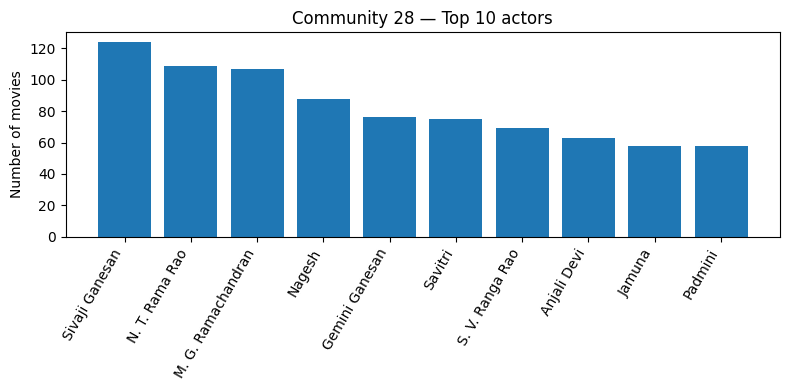


Top directors in community:


,director,count
0,P. Neelakantan,27
1,M. A. Thirumugam,25
2,T. R. Ramanna,20
3,B. R. Panthulu,17
4,C. V. Sridhar,16
5,K. Shankar,15
6,A. Bhimsingh,14
7,P. Madhavan,14
8,P. Pullaiah,14
9,C. S. Rao,14


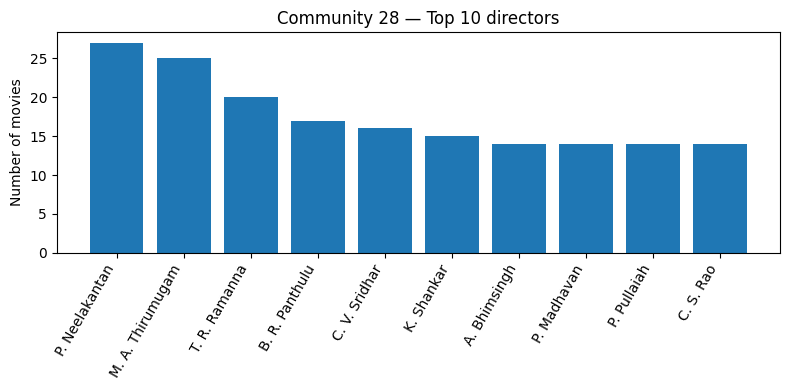


Top genres in community:


,genre,count
0,unknown,635
1,drama,84
2,mythology,17
3,folklore,17
4,romance,11
5,historical,9
6,family drama,8
7,devotional,5
8,action,3
9,romantic comedy,3


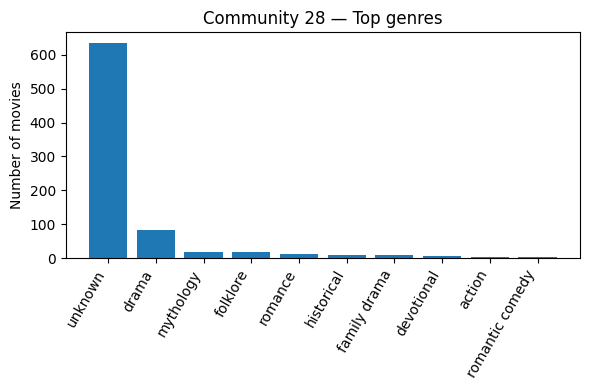


Top origins in community:


,origin,count
0,Tamil,562
1,Telugu,252
2,Bollywood,14
3,Kannada,11
4,Malayalam,2


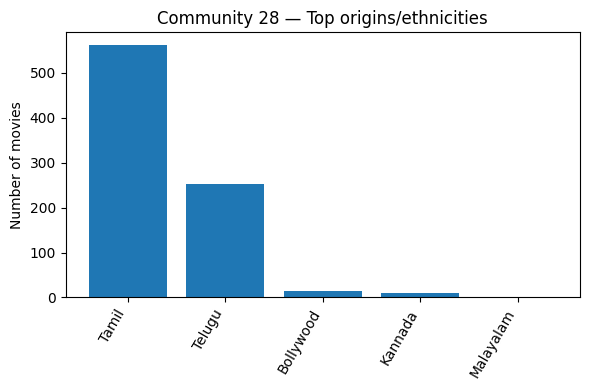

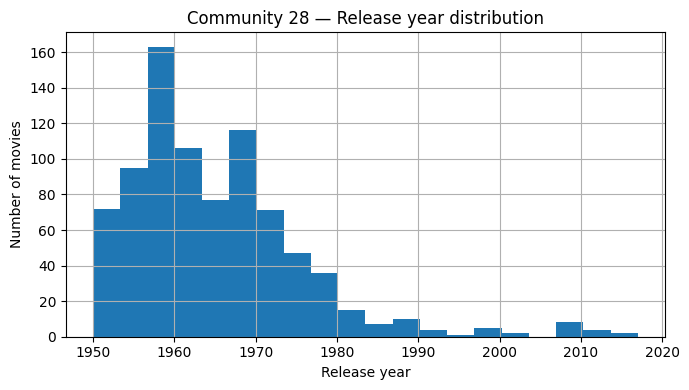

In [25]:
explore_community(28) # Pick a community ID you are interested in (from your Step 8 output, e.g. 0, 1, 11, 16, 22, 25, 28)

##  Conclusion

Σo far, we constructed and explored a large-scale **movie co-cast network** using the Wikipedia Movie Plots dataset. After performing data cleaning, filtering, and preprocessing of cast lists, we built an undirected graph where movies are connected if they share at least one actor. Focusing on the **Largest Connected Component** (≈24k movies), we computed core network statistics such as degree distribution, clustering coefficient, density, and average shortest path length, confirming that the network is sparse but highly clustered and displays strong community structure.

Using the Louvain algorithm, we discovered **29 meaningful communities** with high modularity (≈0.70), indicating well-defined clusters.